In [25]:
from typing import TypedDict, Annotated

from langgraph.graph import add_messages, StateGraph, END
from langchain_groq import ChatGroq
from langchain_core.messages import AIMessage, HumanMessage
from dotenv import load_dotenv
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.prebuilt import ToolNode


In [26]:
load_dotenv()

True

In [27]:
class ChildState(TypedDict):
    messages : Annotated[list, add_messages]

In [28]:
search_tool = TavilySearchResults()

tools = [search_tool]

In [29]:
llm = ChatGroq( model = "llama-3.1-8b-instant")

In [30]:
llm_with_tools = llm.bind_tools(tools)

In [31]:
def agent (state : ChildState):
    return {

        "messages" : llm_with_tools.invoke(state["messages"])
    }

In [32]:
def tools_router(state : ChildState):
    last_message = state["messages"][-1]

    if (hasattr(last_message,"tool_calls") and len(last_message.tool_calls)>0):
        return "tool_node"
    else:
        return END

In [33]:
tool_node = ToolNode(tools = tools)

In [34]:
subgraph = StateGraph(ChildState)

In [35]:
subgraph.add_node("agent", agent)
subgraph.add_node("tool_node", tool_node)
subgraph.set_entry_point("agent")

subgraph.add_conditional_edges("agent",tools_router)
subgraph.add_edge("tool_node", "agent")

search_app = subgraph.compile()

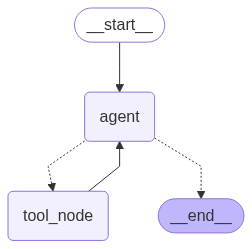

In [36]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
Image(
    search_app.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.API)
)
)

In [45]:
response = search_app.invoke({"messages":[HumanMessage(content = "what is the weather in delhi")]})

In [49]:
print (response)

{'messages': [HumanMessage(content='what is the weather in delhi', additional_kwargs={}, response_metadata={}, id='6c297468-ffc8-47f2-b084-5d3f8a3cd48f'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'jpnynn675', 'function': {'arguments': '{"query":"delhi weather"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 285, 'total_tokens': 305, 'completion_time': 0.032296444, 'prompt_time': 0.020327099, 'queue_time': 0.049225705999999994, 'total_time': 0.052623543}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_510c177af0', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--422c4134-f643-4a1d-9eab-ce1d73a79bf0-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'delhi weather'}, 'id': 'jpnynn675', 'type': 'tool_call'}], usage_metadata={'input_tokens': 285, 'output_tokens': 20, 'total_tokens': 305}), ToolMessage(content='[{"title": "Delhi